# DDQN Model with Flexible Reward Environment for Banking Lead Conversion Prediction

In [2]:
import os
import sys
curr_folder = globals()['_dh']

os.chdir(os.path.join(curr_folder[0], '..'))
sys.path.append(os.path.join(curr_folder[0], '..'))
sys.path.append(os.path.join(curr_folder[0], '../marketing_rl'))

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix, fbeta_score

import tensorflow as tf
import tf_agents.utils.common as common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.networks.q_network import QNetwork
from tf_agents.metrics import tf_metrics
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import TFUniformReplayBuffer

from marketing_rl.environment.flexi_biclass_tf_env import FlexiBiClassTFEnv, EnvMode

## Read Data

In [4]:
data_path = 'data/Banking | Marketing | Leads Conversion Data/train_loan/train.csv'
df = pd.read_csv(data_path)
print('total data size is', df.shape[0])

total data size is 69713


## Feature Extraction

In [5]:
df['DOB'] = df['DOB'].apply(pd.to_datetime)
df['Lead_Creation_Date'] = df['Lead_Creation_Date'].apply(pd.to_datetime)
df['Age'] = (df['Lead_Creation_Date'] - df['DOB'])/ np.timedelta64(1, 'Y')
df['Age'] = np.where(df['Age'] < 0, np.nan, df['Age'])
df['Apply'] = np.where(df['Loan_Amount']>0, 1, 0)
df['Apply'].mean()

0.6025275056302268

In [6]:
label_col = 'Apply'
index_col = 'ID'
date_col = 'Lead_Creation_Date'
feat_cols = ['Gender', 'Age', 'City_Category', 'Employer_Category1', 'Employer_Category2', 
             'Monthly_Income', 'Primary_Bank_Type',
             'Source_Category', 'Existing_EMI']

In [7]:
test_cond = df['Lead_Creation_Date'] > '2016-09-01'
train_df = df.loc[~test_cond, :].copy()
test_df = df.loc[test_cond, :].copy()
print('train size is', train_df.shape[0])
print('test size is', test_df.shape[0])

train size is 45576
test size is 24137


In [8]:
X_train = train_df[feat_cols]
y_train = train_df[label_col]
X_test = test_df[feat_cols]
y_test = test_df[label_col]
print('train size is', X_train.shape[0])
print('test size is', X_test.shape[0])

train size is 45576
test size is 24137


In [9]:
numer_feats = ['Age', 'Monthly_Income', 'Existing_EMI']
numer_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

cat_feats = ['Gender', 'City_Category', 'Employer_Category1', 'Employer_Category2', 
             'Primary_Bank_Type', 'Source_Category']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ("num", numer_transformer, numer_feats),
        # ("ordinal", binary_transformer, binary_feats),
        ("cat", cat_transformer, cat_feats)
    ], sparse_threshold = 0
)

In [10]:
X_train_t = transformer.fit_transform(X_train)
X_test_t = transformer.transform(X_test)

In [11]:
transformers = transformer.get_params()['transformers']
feature_names = []
for name, _, features in transformers:
    try:
        Var = transformer.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

/Users/sukhumarn/anaconda3/envs/mar_rl/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Prep Agents Environment

In [12]:
pos_neg_ratio = sum(y_train==1)/sum(y_train==0)
print('[train] positive sample to negative sample is', pos_neg_ratio)

[train] positive sample to negative sample is 1.595296395421673


In [13]:
early_stop = train_df.shape[0] * 0.5
print(f'[train] early stop is {early_stop}')

[train] early stop is 22788.0


In [14]:
train_df['Loan_Amount'].describe()

count     28015.000000
mean      39237.943959
std       30192.645464
min        5000.000000
25%       20000.000000
50%       30000.000000
75%       50000.000000
max      300000.000000
Name: Loan_Amount, dtype: float64

In [15]:
def normalize_data(value, min_val, max_val):
    new_value = (value -  min_val)/(max_val - min_val)
    return new_value
train_df['add_reward'] = train_df['Loan_Amount'].apply(lambda x: normalize_data(x, 5000, 100000))
train_df.fillna(0, inplace=True)
train_df['add_reward'] = train_df['add_reward'].clip(0, 1)
train_df['total_reward'] = train_df['Apply'] + train_df['add_reward']

test_df['add_reward'] = test_df['Loan_Amount'].apply(lambda x: normalize_data(x, 5000, 100000))
test_df.fillna(0, inplace=True)
test_df['add_reward'] = test_df['add_reward'].clip(0, 1)
test_df['total_reward'] = test_df['Apply'] + test_df['add_reward']

In [16]:
train_data_x = np.array(X_train_t)
train_data_y = np.array(y_train)
reward = np.array(train_df['total_reward'])

In [26]:
train_env = FlexiBiClassTFEnv(data_x=train_data_x, data_y=train_data_y, pos_neg_ratio=1, 
                              discount=0.05, reward=reward, early_stop=early_stop)
train_tf_env = tf_py_environment.TFPyEnvironment(train_env)

In [27]:
eval_data_x = np.array(X_test_t)
eval_data_y = np.array(y_test)
eval_reward = np.array(test_df['total_reward'])

eval_env = FlexiBiClassTFEnv(data_x=eval_data_x, data_y=eval_data_y, reward=eval_reward, 
                        pos_neg_ratio=1, mode=EnvMode.TEST)
eval_tf_env = tf_py_environment.TFPyEnvironment(eval_env)

## Agents

### Set Parameters

In [20]:
# define parameters
fc_layers = (64, 32)
learning_rate = 1e-5
batch_size = 64
replay_buffer_capacity = 100000

num_iterations = 50000
num_eval_episodes = 1

log_interval = 200
eval_interval = 1000

### Set Q-network and initialize agent

In [21]:
# q network
q_net = QNetwork(
    input_tensor_spec = train_tf_env.observation_spec(),
    action_spec = train_tf_env.action_spec(),
    fc_layer_params = fc_layers,
)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
# train_step_counter = tf.compat.v2.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()


# ddqn agent
agent = dqn_agent.DdqnAgent(
    time_step_spec = train_tf_env.time_step_spec(),
    action_spec = train_tf_env.action_spec(),
    q_network = q_net,
    optimizer = optimizer,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = global_step,
    emit_log_probability = True
)
agent.initialize()

2022-07-12 12:39:27.413091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# initiate replay buffer for training
replay_buffer = TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_tf_env.batch_size,
    max_length = replay_buffer_capacity,
)
print("Batch Size: {}".format(train_env.batch_size))

replay_observer = [replay_buffer.add_batch]
metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
    
]

# policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

agent.train = common.function(agent.train)


Batch Size: None


### Set Checkpoint

In [32]:
checkpoint_folder = 'banking_lead_ddqn_cp2'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_folder,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

### Set Dataset Iteration and Driver

In [29]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls = 3, 
    sample_batch_size = batch_size,
    num_steps = 2
).prefetch(3)

driver = dynamic_step_driver.DynamicStepDriver(
    env = train_tf_env,
    policy = collect_policy,
    observers = replay_observer + metrics,
)

data_iter = iter(dataset)

In [30]:
def compute_avg_return(environment, policy, num_episodes=1):
    total_return = 0.0
    total_step = 0
    for i in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_step += 1
        total_return += episode_return
            
    print(f'total step is {total_step}')
    print(f'total reward is {total_return}')
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

### Train agent

In [ ]:
final_time_step, policy_state = driver.run()
episode_len = []
step_len = []
losses = []
returns = []
# agent.train_step_counter.assign(0)
# num_iterations = 10000

for i in range(num_iterations+1):
    # time_step, _ = driver.run(time_step)
    final_time_step, _ = driver.run(final_time_step, policy_state)
    
    experience, _ = next(data_iter)
    train_loss = agent.train(experience=experience)
    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))
        episode_len.append(metrics[3].result().numpy())
        step_len.append(step)
        print('Average episode length: {}'.format(metrics[3].result().numpy()))
        print('Number of Steps: ', metrics[1].result().numpy())
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_tf_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        losses.append(train_loss)
        returns.append(avg_return)
        train_checkpointer.save(global_step)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 1.3820445537567139
Average episode length: 0.0
Number of Steps:  201
step = 400: loss = 1.439034342765808
Average episode length: 0.0
Number of Steps:  401
step = 600: loss = 1.755177617073059
Average episode length: 0.0
Number of Steps:  601
step = 800: loss = 1.524489402770996
Average episode length: 0.0
Number of Steps:  801
step = 1000: loss = 1.6743048429489136
Average episode length: 0.0
Number of Steps:  1001
total step is 24137
total reward is [8693.697]
step = 1000: Average Return = 8693.697265625
step = 1200: loss = 1.4926340579986572
Average episode length: 0.0
Number of Steps:  1201
step = 1400: loss = 1.4188709259033203
Average episode length: 0.0
Number of Steps:  1401
step = 1600: loss = 1.4480516910552979
Average episode length: 0.0
Number of Steps:  1601
step = 1800: loss = 1.4196314811706543
Average episode length: 0.0
Number of Steps:  1801
step = 2000: loss = 1.4481843709945679
Average episode length: 0.0
Number of Steps:  2001
total step is 24137

### Load Checkpoint

In [45]:
num_iterations = 10000
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
print('global step is', global_step)
print('num_iterations is', num_iterations)

global step is <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=50000>
num_iterations is 10000


In [78]:
# episode_len = []
# step_len = []
# losses = []
# returns = []
# final_time_step, policy_state = driver.run()
for i in range(num_iterations+1):
    # time_step, _ = driver.run(time_step)
    final_time_step, _ = driver.run(final_time_step, policy_state)
    
    experience, _ = next(data_iter)
    train_loss = agent.train(experience=experience)
    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))
        episode_len.append(metrics[3].result().numpy())
        step_len.append(step)
        print('Average episode length: {}'.format(metrics[3].result().numpy()))
        print('Number of Steps: ', metrics[1].result().numpy())
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_tf_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        losses.append(train_loss)
        returns.append(avg_return)
        train_checkpointer.save(global_step)

step = 80200: loss = 0.14651313424110413
Average episode length: 45576.0
Number of Steps:  80202
step = 80400: loss = 0.25144684314727783
Average episode length: 45576.0
Number of Steps:  80402
step = 80600: loss = 0.5044105052947998
Average episode length: 45576.0
Number of Steps:  80602
step = 80800: loss = 0.3912681043148041
Average episode length: 45576.0
Number of Steps:  80802
step = 81000: loss = 0.17815321683883667
Average episode length: 45576.0
Number of Steps:  81002
total step is 24137
total reward is [23521.482]
step = 81000: Average Return = 23521.482421875
step = 81200: loss = 0.22383493185043335
Average episode length: 45576.0
Number of Steps:  81202
step = 81400: loss = 0.264889121055603
Average episode length: 45576.0
Number of Steps:  81402
step = 81600: loss = 0.422145813703537
Average episode length: 45576.0
Number of Steps:  81602
step = 81800: loss = 0.43516433238983154
Average episode length: 45576.0
Number of Steps:  81802
step = 82000: loss = 0.210174813866615

### Plot Rewards

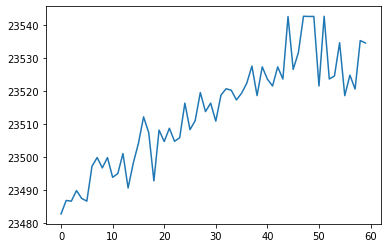

In [79]:
import seaborn as sns
sns.lineplot(data=returns[30:])
# plt.xlim(10, len(returns))
# plt.ylim(13250, max(returns)+500)
plt.show()

## Evaluation

### ROCAUC

In [80]:
eval_q_values, _ = agent._q_network(eval_data_x) 
train_q_values, _ = agent._q_network(train_data_x) 

In [81]:
train_fpr, train_tpr, _ = roc_curve(train_data_y, train_q_values[:, 1])
test_fpr, test_tpr, _ = roc_curve(eval_data_y, eval_q_values[:, 1])

train_auc = roc_auc_score(y_train, train_q_values[:, 1])
test_auc = roc_auc_score(y_test, eval_q_values[:, 1])

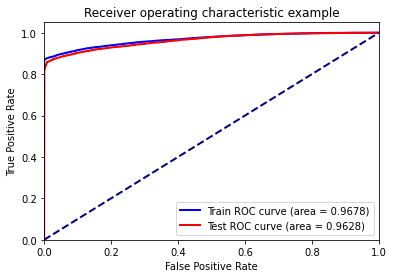

In [82]:
plt.figure()
lw = 2
plt.plot(train_fpr, train_tpr, color="b",lw=lw, label="Train ROC curve (area = %0.4f)" % train_auc)
plt.plot(test_fpr, test_tpr, color="r",lw=lw, label="Test ROC curve (area = %0.4f)" % test_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## Threshold Analysis

In [51]:
def threshold_analysis(result, label_col, proba_col, tops=None):
    if tops is None:
        tops = [1]
        tops.extend(np.arange(2, 6, 1))
        tops.extend(np.arange(10, 105, 5))
        tops = [t/100 for t in tops]

    threshold_opt = pd.DataFrame()

    for top in tops:
        percentile = 1-top
        threshold = result[proba_col].astype(float).quantile(percentile)

        tn, fp, fn, tp = confusion_matrix(result[label_col], result[proba_col] > threshold).ravel()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

        f1 = fbeta_score(result[label_col], result[proba_col] > threshold, beta=1)
        f2 = fbeta_score(result[label_col], result[proba_col] > threshold, beta=2)

        top_idx = top*100
        threshold_opt.loc[top_idx, 'threshold'] = threshold
        threshold_opt.loc[top_idx, 'lead_size'] = (result[proba_col] > threshold).sum()
        threshold_opt.loc[top_idx, 'true_positive'] = tp
        threshold_opt.loc[top_idx, 'false_positive'] = fp
        threshold_opt.loc[top_idx, 'true_negative'] = tn
        threshold_opt.loc[top_idx, 'false_negative'] = fn
        threshold_opt.loc[top_idx, 'precision'] = precision
        threshold_opt.loc[top_idx, 'recall'] = recall
        threshold_opt.loc[top_idx, 'f1'] = f1
        threshold_opt.loc[top_idx, 'f2'] = f2

        threshold_opt.index.name = 'top'

        cols = ['lead_size', 'true_positive', 'false_positive', 'true_negative', 'false_negative']
        threshold_opt[cols] = threshold_opt[cols].astype(int)
    threshold_opt.reset_index(inplace=True)

    return threshold_opt

In [83]:
y_test_score = eval_q_values[:, 1].numpy()
eval_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_test_score})
threshold_analysis(eval_df, 'y_true', 'y_pred', tops=None)

,top,threshold,lead_size,true_positive,false_positive,true_negative,false_negative,precision,recall,f1,f2
0,1.0,1.575987,242,242,0,10148,13747,1.000000,0.017299,0.034010,0.021531
1,2.0,1.550962,483,483,0,10148,13506,1.000000,0.034527,0.066750,0.042790
2,3.0,1.527338,725,725,0,10148,13264,1.000000,0.051826,0.098546,0.063954
3,4.0,1.510521,966,966,0,10148,13023,1.000000,0.069054,0.129188,0.084853
4,5.0,1.495938,1207,1207,0,10148,12782,1.000000,0.086282,0.158858,0.105575
5,10.0,1.451548,2414,2414,0,10148,11575,1.000000,0.172564,0.294336,0.206784
6,15.0,1.420893,3620,3620,0,10148,10369,1.000000,0.258775,0.411153,0.303814
7,20.0,1.399763,4828,4828,0,10148,9161,1.000000,0.345128,0.513153,0.397144
8,25.0,1.375499,6034,6034,0,10148,7955,1.000000,0.431339,0.602707,0.486691
9,30.0,1.352446,7240,7240,0,10148,6749,1.000000,0.517550,0.682086,0.572821


In [84]:
threshold = 1.212451
test_df['predict'] = np.where(y_test_score >= threshold, 1, 0)
test_df['predicted_reward'] = y_test_score

In [85]:
test_df.groupby('predict').agg({
    'ID': 'count',
    'Apply': 'sum',
    'Loan_Amount': 'sum'
})

,ID,Apply,Loan_Amount
predict,,,
0,13275,3127,112951000.0
1,10862,10862,444015000.0


In [86]:
def reward_cumsum(result, label_col, proba_col, cumsum_col, tops=None):
    if tops is None:
        tops = [1]
        tops.extend(np.arange(2, 6, 1))
        tops.extend(np.arange(10, 105, 5))
        tops = [t/100 for t in tops]

    threshold_opt = pd.DataFrame()

    for top in tops:
        percentile = 1-top
        threshold = result[proba_col].astype(float).quantile(percentile)

        top_idx = top*100
        threshold_opt.loc[top_idx, 'threshold'] = threshold
        threshold_opt.loc[top_idx, 'lead_size'] = (result[proba_col] >= threshold).sum()
        threshold_opt.loc[top_idx, 'cumsum_loan_amount'] = result[result[proba_col]>=threshold][cumsum_col].sum()

        threshold_opt.index.name = 'top'

        cols = ['lead_size', 'cumsum_loan_amount']
        threshold_opt[cols] = threshold_opt[cols].astype(int)
    threshold_opt.reset_index(inplace=True)

    return threshold_opt

In [87]:
reward_cumsum(test_df, label_col='Apply', proba_col='predicted_reward', cumsum_col='Loan_Amount', tops=None)

,top,threshold,lead_size,cumsum_loan_amount
0,1.0,1.575987,242,16718000
1,2.0,1.550962,483,30713000
2,3.0,1.527338,725,43773000
3,4.0,1.510521,966,56120000
4,5.0,1.495938,1207,67695000
5,10.0,1.451548,2414,125988000
6,15.0,1.420893,3622,179496000
7,20.0,1.399763,4828,229660000
8,25.0,1.375499,6035,274847000
9,30.0,1.352446,7242,319137000


In [72]:
reward_cumsum(test_df, label_col='Apply', proba_col='predicted_reward', cumsum_col='Loan_Amount', tops=None)

,top,threshold,lead_size,cumsum_loan_amount
0,1.0,1.641599,242,15876000
1,2.0,1.605302,483,28988000
2,3.0,1.574243,725,41198000
3,4.0,1.548216,966,53549000
4,5.0,1.526908,1207,65343000
5,10.0,1.493264,2414,122624000
6,15.0,1.466169,3621,172136000
7,20.0,1.444824,4828,220666000
8,25.0,1.419795,6034,268514000
9,30.0,1.393975,7241,315187000


In [76]:
sorted_test_df = test_df.sort_values(by=['predicted_reward'], ascending=False)
sorted_test_df['cumsum_loan_amount'] = sorted_test_df['Loan_Amount'].cumsum()
sorted_test_df.reset_index(inplace=True)
sorted_test_df.loc[3000, ['predicted_reward', 'Loan_Amount', 'cumsum_loan_amount']]

predicted_reward         1.474449
Loan_Amount               50000.0
cumsum_loan_amount    142427000.0
Name: 3000, dtype: object